In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import isaacgym
import isaacgymenvs
from isaacgymenvs.utils.reformat import omegaconf_to_dict, print_dict
from isaacgymenvs.utils.utils import set_np_formatting, set_seed
from isaacgymenvs.utils.rlgames_utils import RLGPUEnv, RLGPUAlgoObserver, get_rlgames_env_creator

from rl_games.common import env_configurations, vecenv
from rl_games.torch_runner import Runner
from rl_games.algos_torch import model_builder

from omegaconf import DictConfig, OmegaConf

import torch
import numpy as np
import matplotlib.pyplot as plt

from isaacgymenvs.qp.fista import ForceQP, LocationQP, FISTA
from isaacgymenvs.qp.qp_utils import *
from isaacgymenvs.qp.vecrobotics import *

Importing module 'gym_38' (/home/hz/devel/isaacgym/python/isaacgym/_bindings/linux-x86_64/gym_38.so)
Setting GYM_USD_PLUG_INFO_PATH to /home/hz/devel/isaacgym/python/isaacgym/_bindings/linux-x86_64/usd/plugInfo.json


PyTorch version 2.0.0
Device count 1
/home/hz/devel/isaacgym/python/isaacgym/_bindings/src/gymtorch


Using /home/hz/.cache/torch_extensions/py38_cu117 as PyTorch extensions root...
Emitting ninja build file /home/hz/.cache/torch_extensions/py38_cu117/gymtorch/build.ninja...
Building extension module gymtorch...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


ninja: no work to do.


Loading extension module gymtorch...
2023-06-06 16:49:54,248 - INFO - logger - logger initialized
<unknown>:3: DeprecationWarning: invalid escape sequence \*
/home/hz/miniforge3/envs/rlgpu/lib/python3.8/site-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(


Error: FBX library failed to load - importing FBX data will not succeed. Message: No module named 'fbx'
FBX tools must be installed from https://help.autodesk.com/view/FBX/2020/ENU/?guid=FBX_Developer_Help_scripting_with_python_fbx_installing_python_fbx_html


In [3]:
cfg = OmegaConf.load("../isaacgymenvs/cfg/config.yaml")
cfg.task_name = "TrifingerNYU"
cfg.num_envs = 1
cfg.task = OmegaConf.load("../isaacgymenvs/cfg/task/TrifingerNYU.yaml")

cfg.task.env.command_mode = "torque"
cfg.task.env.reset_distribution.object_initial_state.type = "default"
cfg.task.normalize_action = False
cfg.headless = True

In [4]:
def create_env_thunk(**kwargs):
    envs = isaacgymenvs.make(
            cfg.seed, 
            cfg.task_name, 
            cfg.task.env.numEnvs, 
            cfg.sim_device,
            cfg.rl_device,
            cfg.graphics_device_id,
            cfg.headless,
            cfg.multi_gpu,
            cfg.capture_video,
            cfg.force_render,
            cfg,
            **kwargs,
        )
    return envs

In [5]:
lifting_data = np.load("data/lifting2.npz", allow_pickle=True)["data"]

In [6]:
device = cfg.sim_device
envs = create_env_thunk()

/home/hz/miniforge3/envs/rlgpu/lib/python3.8/site-packages/gym/spaces/box.py:112: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/home/hz/learning/IsaacGymEnvs/isaacgymenvs/tasks/trifingerNYU.py:1386: DeprecationWarning: an integer is required (got type isaacgym._bindings.linux-x86_64.gym_38.DofDriveMode).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  robot_asset_options.default_dof_drive_mode = gymapi.DOF_MODE_EFFORT


[Warning] [carb.gym.plugin] useGpu is set, forcing single scene (0 subscenes)
Not connected to PVD
+++ Using GPU PhysX
Physics Engine: PhysX
Physics Device: cuda:0
GPU Pipeline: enabled
Trifinger Robot Asset: 
	 Number of bodies: 23
	 Number of shapes: 39
	 Number of dofs: 9
	 Number of actuated dofs: 9
Trifinger Table Asset: 
	 Number of bodies: 2
	 Number of shapes: 1
Trifinger Boundary Asset: 
	 Number of bodies: 1
	 Number of shapes: 41
Using VHACD cache directory '/home/hz/.isaacgym/vhacd'
Found existing convex decomposition for mesh '/home/hz/learning/IsaacGymEnvs/isaacgymenvs/../assets/trifinger/robot_properties_fingers/meshes/pro/int_sim.stl'
Found existing convex decomposition for mesh '/home/hz/learning/IsaacGymEnvs/isaacgymenvs/../assets/trifinger/robot_properties_fingers/meshes/pro/prox-sim.stl'
Found existing convex decomposition for mesh '/home/hz/learning/IsaacGymEnvs/isaacgymenvs/../assets/trifinger/robot_properties_fingers/meshes/pro/tip_link_sim.stl'
Found existing co

In [7]:
# get ftip states
envs.reset_idx(torch.arange(cfg.num_envs))
N = 3000
action_buffer = torch.zeros(N, 9).to(device)
projected_torque_buffer = torch.zeros(N, 9).to(device)

ftip_pos_buffer = torch.zeros(N, 3, 3).to(device)
ftip_pos_local_buffer = torch.zeros(N, 3, 3).to(device)
object_pose_buffer = torch.zeros(N, 7).to(device)
contact_normals_buffer = []

q_buffer = torch.zeros(N, 9).to(device)
dq_buffer = torch.zeros(N, 9).to(device)
obs, rwds, resets, info = envs.step(torch.zeros(cfg.num_envs, 9))

In [8]:
# construct force QP
batch_size = cfg.num_envs
num_vars = 9
lb = -10 * torch.ones(batch_size, num_vars)
ub = 10 * torch.ones(batch_size, num_vars)
mg = torch.tensor([0, 0, 9.81]).repeat(batch_size, 1).to(device)
cost_weights = [1, 200, 1e-4]

for n in range(N):
    q = envs._dof_position
    dq = envs._dof_velocity
    q_buffer[n] = q[0]
    dq_buffer[n] = dq[0]
    
    ftip_state = envs._rigid_body_state[:, envs._fingertip_indices]
    ftip_pos = ftip_state[:, :, 0:3]
    ftip_vel = ftip_state[:, :, 7:10]
    ftip_pos_buffer[n] = ftip_pos[0]
    
    object_pose = envs._object_state_history[0][:, 0:7]
    object_orn = quat2mat(object_pose[:, 3:])
    object_pose_buffer[n] = object_pose[0]
    
#     time_idx = 0 if n < 200 else 20 * (n - 200)
#     ftip_pos_des = torch.tensor(lifting_data[time_idx]['policy']['controller']['ft_pos_des'], dtype=torch.float32).to(device)
#     ftip_vel_des = torch.tensor(lifting_data[time_idx]['policy']['controller']['ft_vel_des'], dtype=torch.float32).to(device)

#     ftip_pos_diff = ftip_pos_des - ftip_pos.reshape(cfg.num_envs, 9)
#     ftip_vel_diff = ftip_vel_des - ftip_vel.reshape(cfg.num_envs, 9)
    
#     task_space_force = torch.tensor([200,200,200]*3, dtype=torch.float32, device=envs.device) * ftip_pos_diff
#     task_space_force += torch.tensor([5]*9, dtype=torch.float32, device=envs.device)  * ftip_vel_diff
    
    jacobian = envs.get_fingertip_jacobian_linear()
    jacobian_transpose = torch.transpose(jacobian, 1, 2)
    
    action = -0.36 + 0.72 * torch.rand(cfg.num_envs, 9).to(device)
    task_space_force = -1.5 + 3. * torch.rand(cfg.num_envs, 9).to(device)
    projected_torque = bmv(jacobian_transpose, task_space_force)
    
    action_buffer[n] = action[0]
    projected_torque_buffer[n] = projected_torque[0]
    obs, rwds, resets, info = envs.step(action)

In [9]:
weights = [10, 1]
batch_size, num_ftip, _ = ftip_pos.shape
num_vars = num_ftip * 3
diag_idx = torch.arange(num_vars)

Q1 = torch.zeros(batch_size, num_vars, num_vars)
Q1[:, diag_idx, diag_idx] = 1.
q1 = -2 * action

Q2 = torch.zeros(batch_size, num_vars, num_vars)
Q2[:, diag_idx, diag_idx] = 1.
q2 = -2 * bmv(jacobian_transpose, task_space_force)


w1, w2 = weights
Q = w1*Q1 + w2*Q2
q = w1*q1 + w2*q2

In [10]:
lb = -10 * torch.ones(envs.num_envs, num_vars)
ub = 10 * torch.ones(envs.num_envs, num_vars)

prob = LocationQP(batch_size, num_vars, device=device)
qp_solver = FISTA(prob, device=device)
max_it = 20

qp_solver.prob.set_data(Q, q, lb, ub)
qp_solver.reset()
for i in range(max_it):
    qp_solver.step()



In [11]:
qp_solver.prob.yk

tensor([[ 0.2210,  0.2614, -0.2995, -0.1902,  0.0220,  0.1705,  0.1121, -0.2675,
          0.1420]], device='cuda:0')

In [12]:
action

tensor([[ 0.2774,  0.2977, -0.3201, -0.2160,  0.0101,  0.1630,  0.1252, -0.2993,
          0.1421]], device='cuda:0')

In [13]:
bmv(jacobian_transpose, task_space_force)

tensor([[-0.3429, -0.1010, -0.0938,  0.0679,  0.1402,  0.2456, -0.0186,  0.0498,
          0.1410]], device='cuda:0')

In [14]:
projected_torque_buffer.shape

torch.Size([3000, 9])

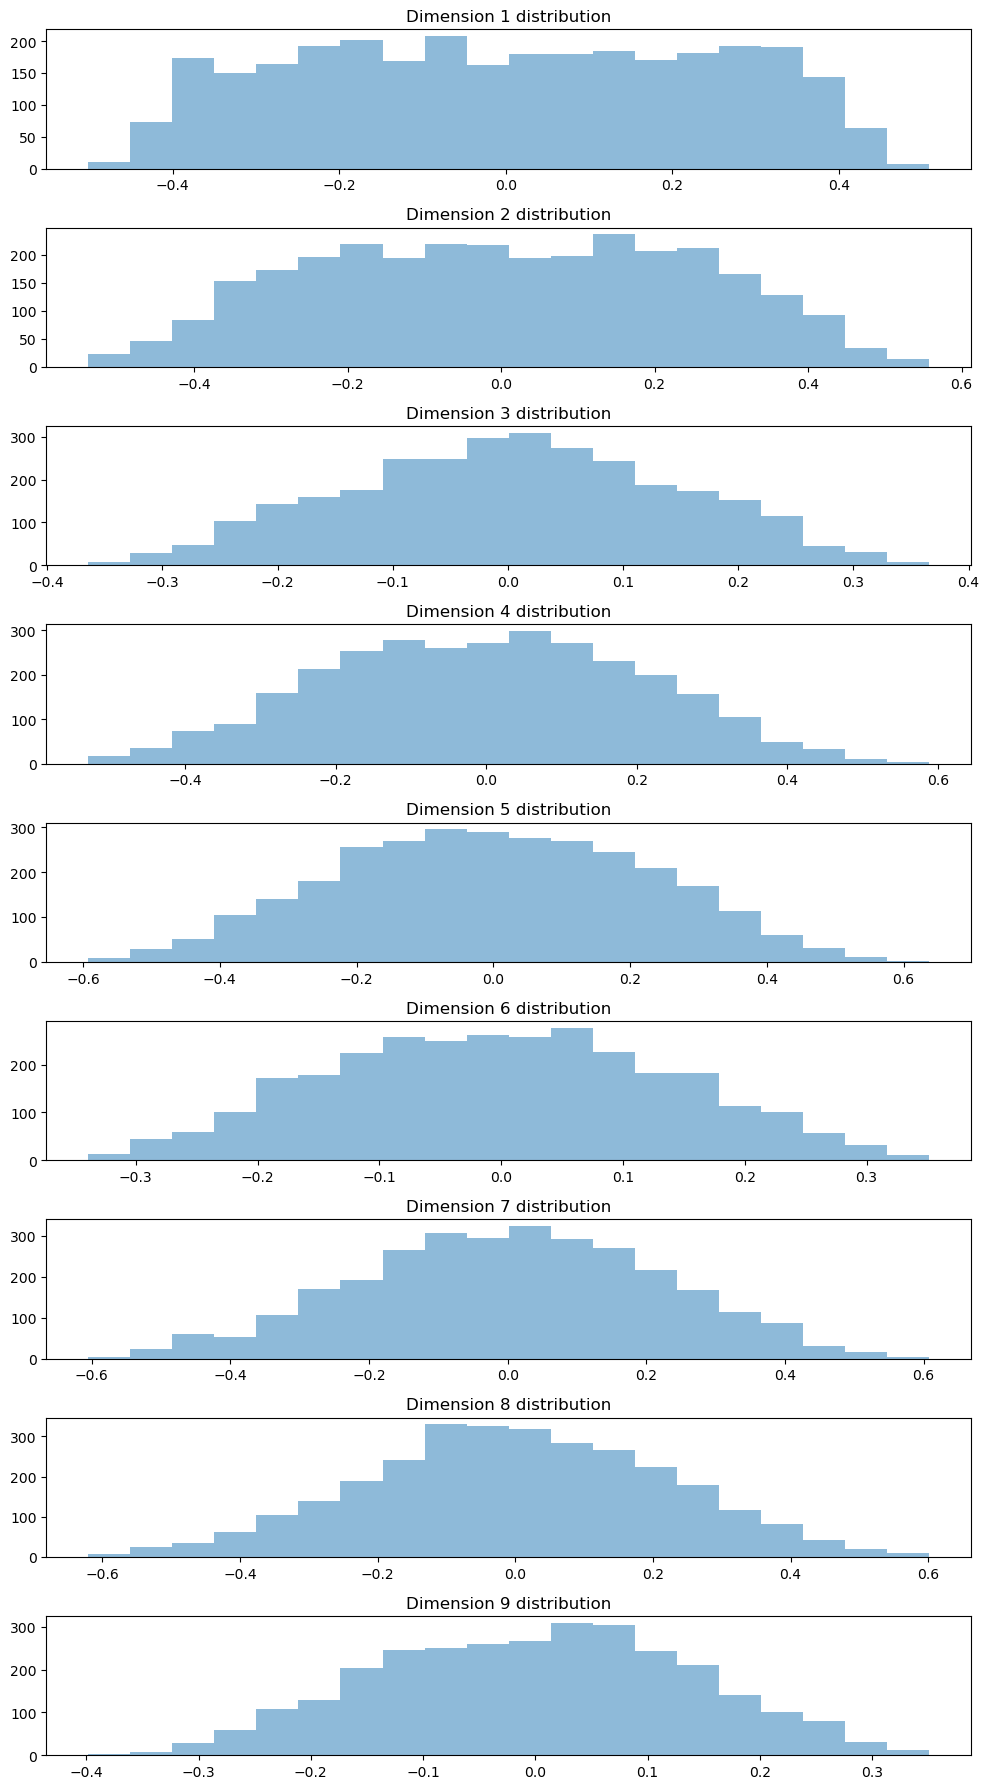

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming arr is your NxD numpy array
arr = action_buffer.to('cpu').numpy()
arr = projected_torque_buffer.to('cpu').numpy()


D = arr.shape[1]  # get the number of dimensions

# Create a new figure
fig = plt.figure(figsize=(10, 2 * D))

# For each dimension
for d in range(D):
    # Create a subplot for this dimension
    ax = fig.add_subplot(D, 1, d + 1)
    
    # Plot the histogram of this dimension
    ax.hist(arr[:, d], bins=20, alpha=0.5)
    
    # Add a title to this subplot
    ax.set_title(f'Dimension {d+1} distribution')

# Automatically adjust subplot parameters for better spacing
fig.tight_layout()

# Show the figure
plt.show()